<a href="https://colab.research.google.com/github/ptran1203/gan_project/blob/master/try_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content

/content


In [2]:
%tensorflow_version 1.x
from google.colab import drive, output
drive.mount('/content/drive')

!rm -rf '/content/gan_project'
!git clone https://github.com/ptran1203/gan_project
!pip install git+https://www.github.com/keras-team/keras-contrib.git


TensorFlow 1.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'gan_project'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2275 (delta 0), reused 1 (delta 0), pack-reused 2272
Receiving objects: 100% (2275/2275), 1.29 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-cm2sfdqp
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-cm2sfdqp
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=8cff0521971d6294b240d3fadd9c476b8f1bb1b04d8a9df0562ae13ca9530c24
  Stored in directory: /tmp/pip-ephem-wheel-cache-zjidlz_m/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully bu

## Create the link from this drive folder to your drive.

---


https://drive.google.com/drive/folders/1RNJXceXkNatuAbNn-CKB8MrgaEHG5RpM?usp=sharing

In [3]:
cd gan_project

/content/gan_project


In [4]:

# K.common.set_image_dim_ordering('tf')
BASE_DIR = '/content/drive/My Drive/bagan'
DS_DIR = '/content/drive/My Drive/bagan/dataset/chest_xray'
DS_SAVE_DIR = '/content/drive/My Drive/bagan/dataset/save'
gratio_mode = 'uniform'
dratio_mode = 'uniform'

from new_gan import *
from batch_gen import *
from utils import *
from tensorflow.keras.layers import LayerNormalization

def create_dir_if_any(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

class Bagan(BalancingGAN):
    attribute_loss_weight = 1
    def interval_process(self, epoch):
        if epoch % 400 == 0 and epoch > 0:
            output.clear()
    
    def get_pair_features(self, image_batch): return 0,0
    def backup_point(self, epoch): return
    def evaluate_d(self, test_x, test_y): return
    def evaluate_g(self, test_x, test_y): return

    def build_features_from_d_model(self):
        image = Input(shape=(self.resolution, self.resolution, self.channels))
        print(self.discriminator.layers)
        model_output = self.discriminator.layers[-3](image)
        
        self.features_from_d_model = Model(
            inputs = image,
            output = model_output,
            name = 'Feature_matching'
        )

    def latent_codes(self, k_shot_images):
        """
        Predict for k_shot images
        shape = (batch_size, K_shot, H, W, C)
        return: array with shape (batch_size, latent_code_size)
        """
        # return mean per single k_shot images
        return np.array([
            np.mean(self.latent_code(i), axis=0) for i in k_shot_images
            ])


class BatchGen(BatchGenerator):
    # to_train_classes = list(range(0, 5))
    to_train_classes = INVERT_CATEGORIES_MAP[:10]
    to_test_classes = list(range(81, 86))


is_test = 0
## Test batch GEN
if is_test:
    bg = BatchGen(BatchGen.TRAIN, 64, 'multi_chest', 64)
    labels = np.array([0, 0, 1, 1, 2, 2, 3 ,1])
    samples = bg.ramdom_kshot_images(4, labels)
    print(samples.shape)

Using TensorFlow backend.


## **Run experiment**

---



load data from /content/drive/My Drive/bagan/dataset/save/imgs_train_64.pkl successfully
5229 5229
Remove 0 items in class 0
Remove 2500 items in class 1
load data from /content/drive/My Drive/bagan/dataset/save/imgs_test_64.pkl successfully
621 621
input data loaded...
img shape (64, 64, 1)
Class counters:  [1349, 1380]
LOSS TYPE: Hinge
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Latent model modified at:  2020-06-18 06:31:46
[<keras.engine.input_layer.InputLayer object at 0x7fe4980b91d0>, <keras.engine.sequential.Sequential object at 0x7fe4980b9940>, <keras.layers.core.Dense object at 0x7fe498045668>]
INFO: Use resnet generator


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="Feature_matching", outputs=Tensor("in...)`


['loss', 'discriminator_loss', 'model_2_loss', 'discriminator_accuracy', 'model_2_accuracy']
['loss', 'accuracy']
init gan
join() argument must be str or bytes, not 'NoneType'
gan initialized, start_e:  0



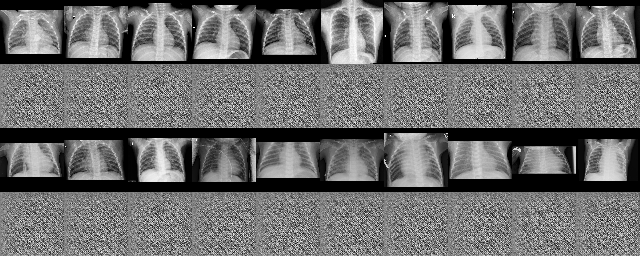

In [ ]:
gan_epochs  = 400000
# Discriminator learning rate
adam_lr = 0.0004
# Generator learning rate
g_lr = 0.0001
batch_size = 128
# dataset_name should be "flowers", "chest", "multi_chest"
# "chest" is binary classification, "multi_chest" using chest-xray14 dataset
dataset_name = 'chest'
latent_size = 128
# Use resnet architecture for Generator
resnet = True
# Use self-attention mechanism
attention = True
np.random.seed(0)
# Image resoulution
rst = 64
# Number of images used to generate feature for Generator
k_shot = 2

norm = 'in'
# Adversarial loss type
loss_type = 'hinge'

is_prune = dataset_name == 'chest'

# prune = [700] * 11 if is_prune else None
prune = [0,2500] if is_prune else None

res_dir = BASE_DIR + '/result/model_v2_{}'.format(rst)
create_dir_if_any(res_dir)

bg_train_full = BatchGen(BatchGen.TRAIN, batch_size, dataset_name, rst,prune_classes=prune)
bg_test = BatchGen(BatchGen.TEST, batch_size, dataset_name, rst)

channels = bg_train_full.dataset_x[0].shape[-1]

print("input data loaded...")

shape = bg_train_full.dataset_x[0].shape

print('img shape', shape)
classes = bg_train_full.get_label_table()
# Initialize statistics information
gan_train_losses = defaultdict(list)
gan_test_losses = defaultdict(list)

img_samples = defaultdict(list)

# For all possible minority classes.
target_classes = np.array(range(len(classes)))


print('Class counters: ', bg_train_full.per_class_count)

# Train GAN to balance the data
gan = Bagan(
    target_classes, loss_type,
    adam_lr=adam_lr, latent_size=latent_size,res_dir=res_dir,image_shape=shape,
    g_lr = g_lr,
    norm = norm,
    resnet=resnet,
    dataset=dataset_name,
    attention=attention,
    k_shot=k_shot,
)
print(gan.combined.metrics_names)
print(gan.discriminator_fake.metrics_names)

# plot_model(gan.generator, to_file=BASE_DIR + '/gen.png')
# gan.init_gan()
gan.train(bg_train_full, bg_test, epochs=gan_epochs)


Test classifier model


In [ ]:
def l2_dist(x, y):
    return np.mean(np.square(x - y))
def cosine_sim(a, b):
    return -np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

def pred(sp1, sp2, x, opt='l2'):
    metric = l2_dist if opt == 'l2' else cosine_sim
    dis_1 = metric(x, sp1)
    dis_2 = metric(x, sp2)
    if opt == 'l2':
        print('Dis_2, Dis_1', dis_2 ,dis_1)
    if dis_1 < dis_2:
        return 0
    return 1

test_size = 1000
test_data = False
bg = bg_test if test_data else bg_train_full
sp_1 = bg.get_samples_for_class(0, 1) # class normal 
sp_2 = bg.get_samples_for_class(1, 1) # pneumonia
query_1 = bg.get_samples_for_class(0, test_size)
query_2 = bg.get_samples_for_class(1, test_size)

# query_1 = gan.generator.predict([query_1, gan.generate_latent(query_1)])
# query_2 = gan.generator.predict([query_2, gan.generate_latent(query_2)])

s_embedding_1 = gan.latent_encoder.predict(sp_1)
s_embedding_2 = gan.latent_encoder.predict(sp_2)

q_embedding_1 = gan.latent_encoder.predict(query_1)
q_embedding_2 = gan.latent_encoder.predict(query_2)

# labels = [0] * len(q_embedding_1) + [1] * len(q_embedding_2)
acc_count = 0
acc_count_2 = 0
for e in q_embedding_1:
    if pred(s_embedding_1[0], s_embedding_2[0], e) == 0:
        acc_count += 1
    if pred(s_embedding_1[0], s_embedding_2[0], e, 'cs') == 0:
        acc_count_2 += 1

for e in q_embedding_2:
    if pred(s_embedding_1[0], s_embedding_2[0], e) == 1:
        acc_count += 1
    if pred(s_embedding_1[0], s_embedding_2[0], e, 'cs') == 1:
        acc_count_2 += 1

actual_size = len(query_1) + len(query_2)
print('L2 Accuracy: ', acc_count / actual_size, '{}/{}'.format(acc_count, actual_size))
print('Cosine Accuracy: ', acc_count_2 / actual_size, '{}/{}'.format(acc_count_2, actual_size))
plot_data_space(np.concatenate([sp_1, sp_2, query_1, query_2]),
          np.array(['nor'] + ['pneu'] + ['fake_nor']*len(query_1) + ['fake_pneu']*len(query_2)),
          gan.latent_encoder,'a')

In [ ]:
epoch = 600
print('Save weights at epochs : ', epoch)
generator_fname = "{}/bck_generator.h5".format(gan.res_dir)
discriminator_fname = "{}/bck_discriminator.h5".format(gan.res_dir)

gan.generator.save(generator_fname)
gan.discriminator.save(discriminator_fname)

Plot data

In [ ]:
bg = bg_train_full
x, y = bg.dataset_x, bg.dataset_y

test_size = 500

class_1 = bg.ramdom_kshot_images(5, np.full(test_size, 0))
class_2 = bg.ramdom_kshot_images(5, np.full(test_size, 1))

fake_1 = gan.generator.predict([class_1,
                                gan.generate_latent(range(test_size))])

fake_2 = gan.generator.predict([class_2,
                                gan.generate_latent(range(test_size))])

x = np.concatenate([x, fake_1, fake_2])
y = np.concatenate([y, np.full((test_size,), 'Pneu'),  np.full((test_size,), 'Normal')])
# utils.plot_data_space(x, y, gan.features_from_d_model, 'latent encoder')
# utils.plot_data_space(x, y, gan.latent_encoder, 'latent encoder')

print(np.mean(np.abs(gan.latent_codes(class_2) - gan.latent_codes(class_1))))

show_samples(class_1[:,0,][:10])
show_samples(fake_1[:10])
show_samples(class_2[:,0,][:10])
show_samples(fake_2[:10])

Test generated image

In [ ]:

# bg = bg_test
bg = bg_train_full
idx = np.random.randint(0, 200) 
ss = np.random.randint(0, 200)
x = bg.dataset_x[idx]
rst = x.shape[1]
x = np.expand_dims(x, axis = 0)
channels= 1
if 1 == 1:
    y = bg.dataset_x[ss].reshape(1,rst,rst,channels)
else:
    y = bg.dataset_x[ss:ss + 10]

label_x, label_y = bg.dataset_y[idx], bg.dataset_y[ss]
label_x_r = 1 if label_x == 0 else 0
label_y_r = 1 if label_y == 0 else 0
latent = gan.generate_latent(range(10))
latent = np.random.uniform(0.3, 1, 10*128).reshape(10,128)

size = 0
latent = np.concatenate([
    np.full((1, size), 0),
    np.full((1, 128 - size), 1)
], axis = -1)


gen = gan.generator.predict([x, np.random.normal(0, 1, 128).reshape(1,128)])
attr_img = x
for i in range(9):
    temp = bg.get_samples_for_class(label_x_r, 1)
    img2 = gan.generator.predict([temp, latent])
    gen = np.concatenate([gen, img2])
    attr_img = np.concatenate([attr_img, temp])

gen2 = gan.generator.predict([y, np.random.normal(0, 1, 128).reshape(1,128)])
attr_img2 = y
for i in range(9):
    temp = bg.get_samples_for_class(label_y_r, 1)
    img2 = gan.generator.predict([temp, latent])
    gen2 = np.concatenate([gen2, img2])
    attr_img2 = np.concatenate([attr_img2, temp])



def percep(x):
    return gan.perceptual_model.predict(
        triple_channels(x)
    )


# pred1 = np.argmax(gan.discriminator.predict(x))
# pred2 = np.argmax(gan.discriminator.predict(y))
# pred3 = np.argmax(gan.discriminator.predict(gen[2:3]))
# pred4 = np.argmax(gan.discriminator.predict(gen2[2:3]))
print('label_x, label_y: ', label_x, label_y)
# print('x, y, x2y, y2x: ' ,pred1,pred2,pred3,pred4)



show_samples(x)
show_samples(y)
show_samples(attr_img)
show_samples(gen)
show_samples(attr_img2)
show_samples(gen2)

def dis(x,y):
    x = np.expand_dims(x, axis=0)
    y = np.expand_dims(y, axis=0)
    f1=gan.latent_encoder.predict(x)
    f2=gan.latent_encoder.predict(y)
    return np.mean(np.square(f1 -f2))


print('fake dis: ')
print(dis(gen[0], gen[1]))
print(dis(gen[0], gen2[2]))
print('real dis: ')
print(dis(attr_img[0], attr_img[1]))
print(dis(attr_img[0], attr_img2[2]))

In [ ]:
import urllib.request
from PIL import Image
def get_img(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    img = cv2.resize(img, (rst, rst))
    img = add_padding(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = (img- 127.5) / 127.5
    img= img.reshape(1, rst, rst, 1)
    return img

y = get_img('data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMWFhUXGRkXGBgYGRgeHRoYGhgaHRgeGBsaHSggGxsnHhcaITEhJSkrLi4uGCAzODMsNygtLisBCgoKDg0OGhAQGi0lHyUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAMIBAwMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAADAQIEBQYABwj/xABDEAABAgQDBQUGBAQFAwUBAAABAhEAAyExBBJBBVFhcYEGEyKR8AcyobHB0RRC4fEjUmJyFTOCkrKDosIkQ1NjsyX/xAAZAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX/xAAoEQEBAAICAwABAgYDAAAAAAAAAQIRITEDEkEiE1FxgZGhsdEEMmH/2gAMAwEAAhEDEQA/ANzKlBNBBWfn8YcUaG+kBVKO6PmvQVZao9GAypwWl/Q574N3OYMb+vhAZMgppp9PP18iipm3BFQzHhCTCk6109GDS5Lvv9NEKdILvBTpiN4cQ1IbUkRwSVJp73O8cQaMDxENmhRN9H7w4Td8BQ4I3fWCrTRz6EDQomPC5xEJZYsKiJMsmoP78uMDQqlUrXjCFINxXfEcAguxbUc4MC29ngOVLy6ONX+BHKDA3HHhDCdLi7wwTKseT8OcEOXMaGme32Pq8MmJu0cUApq/KGld3rmohyFgkDWBCZRtBSsclQ6ecAUPxpDcNOVnU9qAcaVLafpD0KHOGTEtbpy+8EDnzgFgUuAb67qFzaHGcklnqKHmz084RKt8NMlObM1TU3uzQURM0NwNoKk5hQ1gUxJAcVGv6iElrBsRFQZaw1bwoS4qL2MAQghzesSJagfqN0QJ3Y0ofWkBmyiK6erRIWkGoNYHiJpSkkAk7h84BAIUppaIcvaqsykmX7hALVcHUUieqekXPBvlDRdm5OPzjoN3Y3R0APvnh6ZiTrT5GIhUbGGgMX30oYgmg1t016b4WZUNqKv6+P6RGmONb6jhBQpxWh0MA9CmvBAXv6MRyRYtXQ68uMRtrqWmRMMuYELyslamZBNAou9A71BtFk3dCx7itPIm3KEVKBNXjy/b/tUWhCJMgy5s4J/izwGRnq/dJIDh6uaaNFN2XOJ2gZpXtCbLmiqEhZGY3LBw1EkUt1jvPBfrPvHshwzWYi7Qnd0b5R5vs7HbVkyFYgzkTUpmzZRRNHiJlnKcpDFRJBZI3RsMd2jRhu4l40GVNmoEwlIJQgn8hN8w1PHrGb4covtFotAO7gR6tHJQwrzHGG4ecmYkKQpKxcKSXBHMQVKNxodDv4Rzsa25Y5Hnu/eHoINCIGEkEsxBr11EOyAsrX1SICN6H1ga5IgoO7WFHi58IIjpSSA++ESk630/WCpH2gijv6w2IMyW9U0I95PH7REmpUkghx61i4WpLhyM1hvPTp8ISZLCgzWrzgqpTOUxceuBtB5IJDCsFVKYvysWjkSqe854i3poKUJdqfvDpks6awspLgDX5iC5m+cECFnF9dx+sCmSS4LMeGsGJDU8vVo4EcW+XKASQDrp8RxhyUC/SE7ytf3hwmAV0+HWAGtNWHKOEurufPzH6QSYyg8dLU9Hrof1gBqw9aD9obOw7sOLjpBCsp1biPtrDkz3HqhiCOW4+Z+8dEhwY6ArDO49YdKnjfCrwu/y+o9cIi4jCqS5T5ft6tFRZJmDd1EPCnF3EUi5qmfdcAWgsqcSHf4xrQsVUqqwNDeofyP3jN+1Xafc4Hu0+/OIlg2ZN1Hyp/q4RZiYVEi2YfH5PGc9o+QSZSpihmSSEppmU4DsGswrYDyB6YT8ol6eV7KmJkzUzFyRNQDVCgKuGvYdY0PZ/ALTiFTMP7qqhKnGVJFruC/hD1pFJs5pswmb4UKaVwR3gUEHm6SeISoG8emdi8KJ4TMQlCTmK1NRKkzpBmpSo3aXiGS4sFJG+PZ7acNbXfZns+oz0rmFylSpyxonMoqPIqW5aLnES5c/ac5cxu7wWHDk+6Jk51qJfVMtCf8AfFH2q24uRhcY8sS82FKlVBWmeuamUlLpJSQHJoSxB3GGdosWSjaOF8QWtOCVOUGBInpTLWBxcCn9REZt2umeOyDKwkzacmbMkLnLBw0pDMUqVllhSDRRVSmgiSjtticEtEnacoArGYTJTWf8yftvjTTUy520xL8KcHsuSFM9BOyskkbkISpjvEVvZ+QjFHE7ZxIAlKCkSAv8uHlEuovYqIPKu+MZYy9tTKtLs3acjEJJlTULTvQXZ/kbxIZnBD6R4qjYs2ThZm1pU1WHKllUmWAzy1LypzCocuGFm4WuOz/tQUgS0Y2WrxMe8AZ02BbUUdxxjjl4b8bmcepy5nr9fVofmq+sQJWMlrSlaVBSVMUkag7vN/MxJSvmI8+tNjrmAwzvwFBAUlyCWerctf0gZOpHl8YrsdKBWhaVFKvEAW4WdqO78Wi6FghR7xRJYZUhm1c1J6kRIE8OEPUjMBws/wAQIoUJecpRJzPRDgDIAL0clw/UCLcrawLQ0Us3zGv6Q1L/AHtC5/Xzgoa+kEAlpq78nESVb/RhikjXWOSWIYUL8qN8awCKl6w1SXHH166QVQ1ApAyN2nyhoN7unGGFB8qGFM191+OsJn4engphU2loJMQFB98IpIfMNeFW3fOGmYEVJp6LeUARtLj5GIuNVkGYPS/m19L/ABh8+cQAQku7aBn1vo3xiux2RRBFQVBhmdyElxlJZKTXSGiJAnKFjlG6lIWIcxiXSsBJqA6baX4R0NK0U2RvNPgYRcg5cqaEM3S3SDZyzeUDK2iMoc7CBsyAy93P6QNGBFwL1I3HXpFgF6jnBAQ0WUVq8BmDg1EeM9s8SuZjJyVF1BSpaeCEk+EbrEmPcNp41GHkrnr92Wkq57hzJYdY+ecQVrWZkw5TMKlqO4LPiLh2fMz3YlnzJf1f8ffNc/J0l9n1YdKgufNKEFcmalBStQWES1kghINM6wHIa8erbH2ajDhBlnMEpSlKmUAsLVKKXBAOZSu5TUazWtGKws6WiZImYnZM5IASETRMUlgkhs0sDKgB7Eg83j0L8d3q8OWAQqbhJzhQPvYjEjKTqUKMoHcTHTLlmK3tns5MzLlqJk7BoVUMpIxc1Sif7lYpJ6CIM+WqbOxs382M2hg8NK/tw6kzFHkyA/8AaY0CcJ3smRn8OQ4Yne6V4BdeqZkZfZWLySpU9R8WHw68bldx3+KC04d95y1/eEqqva20FfgtoTpZc43HKlA/zyQibMAY73Skxou1qu9XgNhoOSWRKM/L+ZCEqOQbqSirqnjFRidlAYnY+BcvKQudPF8qljvTm6JIroRBuyuJTP2vi8cs/wAOQJszPoEuqWgj/pPb+WKJnbBAx+PkbLlD+Bhx3uIy2GUMlHRwG3r3pjMbY2b/AIntCZLlJAw+DllBULEgUD8VMnkkmJ3swxy+82liRfuTMBP5VKXMUl+Dh+kM7BdozhcCmZ3aVCfjUSphIqUqlys6gw8Rqq+pMTo0q/Zvt5MuaZE5jL/KTooE1pU3Abhvj1vK/iCiQN1m479OTx5FNXhsLg1qVhJE2fKxi8MVLz+MJSVFVFAg6brFnePQcDPCdoT8FLzISmQmfLyqUpvdCktMzAh1uAAI5eTD25jeN1xVrhpkwqykgke81Lh0lIPlz8oDtMAZWq6sw4EDR6DgIz3ZvtWvEYObiAhKsRhwSqUlBTmpmTl8RLEA6e8k0oHkbE7XyscChKUiYyVlOZRbQtmlgFlEBw4qI5/p5Rr2i9IJUFkpoKuKtahFAXIJ+sT5LtvjF4X2gSpswyBKZebKM6iM5Djwsgsafmy3gG1+3U2VNlSjJEkTADnmZQEpJqXzKBbcRF/Sy6S5R6EljaIGP2tIk/5s6WjgpSQW5X/aPJ5u0cXj8TMlSVd6gHL3xz5AhqkpB7up0Ca05w7b82ThWkKVNnzx72RQlJDigX3YBtXLXiRG54Z9Z9m9n9tMPUIExbBycigkce8Iy+ZEU+I9pslFwgHcZmb4yQsebRjez/Z/HY+UEqmFGGSaKWCyj/SAxmM9yWG+NLjMNgtjSnbvMQoeF2zq5t/ly+V21Ma9MJxrdJbefi92L2rxeJUMmFKJZdpkyWQki7uZoJHEJN9INhu2uEqmZiZKVpJSUnOkJIUQRmqk1BsbVtHk8zam0Npze6RnW/8A7UpwgDeurN/Usx6P2V9lUiUnNjf4802loUoISG1IZSjxoOGsMsMZ3/Ylt6atGIRNR3klSZqSRWWpKxepdJo1aUtDgmtL/WI59n+AQM6JHclNe8RNmoUnjnCvnEdXaDASzlO0ZKyBqtClciqWMquofeTHG4b6bWsoaFxz+sKtPSrHh6MMMwEJKSCFVSQaFJZjSjVhxmPz15a136xzUOaHllNLm+hU7dC5EVqMIlLkCrkpFj4rihqR4q6RcOkpKa19XgK5biwzCxLXZun7xFjOTilBKe9ZtDHRYzUhzmQ5dyedY6Kq/mK1FvrugQm6NDZTkVp8IbPlNXT03LXq8YZFSvdXX160g8tY0N9Ht+kQ0771BBF9xf7wDG40SpEyeogCWlai1jlBIHM7t73iwY7t5tYT55wwUEyZDKnElgqbRkXDpS9Wq9KFjFDPw6EhE2dMXLlksmZKliYc1Df3ZfvBi2Y1yhIHixGBlKnqWpaxmUrMcxHiUskn4vHpWFEyTJ/EScPOxEuaJcnFYdYzpJSgpUtCkh0FJQ3iSB4g1AG9+vWSRx3vkuwPxWBnysQjEKxeCnrlylKKipjMUEnMFElJBNxdmItFnhpaZYnplsEyl4/uhoAhWGnpbgmckgczFfP7hGDmLwEtYROMhYlLJeXi5OLkJZ1EuFiYNbS/J/ZvYeNmhctSDLliVOkCZMoVLnTknETmqS+VWVIvSoBiW/usXHb3bwk4SeiTWbMmIky0g1BVJlKJHEd6G5iKdWCTN2lhtnJrLSJc2fVwru0SwAdyRKkpA4zjviN2v2JMw2NE+arPIzKnhamoJctKZcsDekknyesU3Z3GrkYPGbTUf4+IJw8kG/jfOoctB/8AVxhjZeizS92dtATp+2dopqEYeaJZO9aciP8AtlDzir2GgSdjbQnVBnTZWHB/mSFJUQOGWYYJsVPc9nsVMNDisQmWjilBQG/7ZnlDJzq7PS2dhjWruTLLdPAI2mzezUsDYm0V2JKUE8hLIHLxKH+qIUxkbBwyrKOMK0k/05w7bvDbhE1KxK7OTCSAZ2IYb1ETQ48pR8oh4xJ/wHBlgScSoJHXEfWGuf5n+kntVgsveoIcHark7wuSlXyMavCzsvaZQP5pOQcu5Sv5oMU3bJQH4pRsnacgk7gMOl4m9rJn4ftBhZxomYmXXR1d5J+qT1jMVB7HKOH21ipFhMVPSByV3sv/ALAr/dFBj8P/AIbtYt4ZQWDu/gTfeHJLlv7BGi9oL4PauHxoHhXlUr/QyJgDa5CPOBe2nZ7zcPiRVEyWZRVo6XUjzSpR6Qnc/wDS9O7XbHRhNpYTFMEyps1PebkrChmVyKVZuaVHWKb2tIIxwSHpIRlH+pdo1XbMDF7CkYlwSgylK/uYypg/3E+UVHYnZczamJGIxMzMjCiUhgADMKSooST0dRartDHjm/C88T62W3AjZmzSZQAMtCZcul5qqZyNS7qL7jHlnYrZBxuOlIW6wSZs4m+VJdWY/wBRIB/ujd+2XaSCmThQXUFd8vcPCQkHicxPTiId7Dtn0xU5rlEkHkCpX/JHlEx4xtMubI2HaXaMrA4dWImMw8EpA/MojwpSNLdADHz9hcJP2jjQlRebPW6lfypAdR5JSKDgBGz9pW3lYzGGRLBMuSTKQA5zLcBZb+4BI5cY2HZvsb+AleABWMmo/iLVUSkH8qW466kbgIT8Md/S/ldJ/ZbCypQOGwaQiWgtMmMCVL1r+ZdKk2iPt/2l4XDEy8On8RMFFKCgEAjRS6lR/tDcRGM7b9pDhx/h+EUQEhp838yiRVKTpfxHpoYidk/Z7OxgTNKu5kfzM6l1r3ad39RpwMZxxneTWV+RR9p+1OMxpPfzlFJYd0h0y70GQHxF9S5i/wCyHsoxWIKV4l8NJvVu9UNMqfyc1VH8selbI2Vs3AKAloCpwpmI7yY7b7I5Bo0Etc+dYdynearI4DSNXyfMWfT7UVWz5ElCZUgJSlCWyJrl3E7iavxrEKYl24cN9HHr5RcYw4fDJRJ91c4skCqllIKipXANU2rxiCQCbNHm8k1XTGoCVFz83406vTyh6ZxDEhybsGHPn9oMuQGLX+tfXSI65YyNpxFmNvm3KMRo9Jf8sdCygphQHj6EdDSbTpiSkvpu+26OJH3pv1gqZ4qFVB9V4wyfJN0m3wiIjy5TFmpp+kZ/t9gZi8BiRLBK8lhcgKSpYDXJSk04RokzD03ceHGCoWQpiOkJdXavlzByit0pDksBwQXKy5oLJ+MegdlMXjZZTLkg5lZpctQYKUChQdSiaJDqWA48WtI2e2/Z5ImTDOwx7mYpyoM8tT+86RVJtalbRZ9mezn4ZIWtYmTRZQDBIrRI6nzj05eaWOcw0lYTswCoLnrKimcmaEpNFFAIQZmYVU5zkhnKUbq35GW1rU0bdAU4gcIVczdppHG5ba1pF7RbCk47DqkTgCkkKSrVKh7qhqLseBI1jwLtpLxAxScF3RR3TIlo0VmAGYaFNGB3A8Y+ikTHqBzEV3aDYaMWlJYCbLcy1kVDhil7hJo/IRvx5+qWbeQdudoplYfB7OQXElJmLIcOpilJ6kzCecWGPAl9ncMF0MzEqWkakHvWPVIfkRGI7VYDEHaC5MxJEwqShIP8rDKR/Szl+caL2h44CVgcJmIlSksWFcgyIfmwVHqnOnPpXdsMUUYDZ+FZjkVPI3d4olD8TmV5Rpe0+FynZGy0e8hUtcxtCVAE/wD6qig2Ck7R2kcQsZZEkhbGyUI/ykfBzyVGg7F4wT8bjtrzQ8uQhZlv/YQkDcRLS3OZFqQTtjKE6RtjLUS8Vh19ciUL8q+USu1OF/xLY+GxqKzZCf4jXaiJ3ktIXyB3wfsjIH4OTLxCQ+1JmIVNL1/iS1KlkdEAj+8QD2ZzlYPFTtmYsPLmkprYqUGBH9ExIA5gcYxGkjbi/wDE9i98A8+QM5a+ZFJo6pdQH9sRezqztPY8zDGs/DN3W85QTK8wFS+kD7NpVs7auKwM0/w5qStFaKYEpIG8ocHihtIpfZ/ivwW1jh38C1Kk9PelE9Kf6jD9/wCqrf2W4tOLwWL2ZMvlUuW/8q6HqmZlV/r4RK9hs8g4uQoMpJlqINwQVpWOhCYz+0Vf4bt4rT4ZZmBf/Tnf5nQEr/2iNgjAfhNuoWmknGpmppYTGClg81ISf9Zhf8kef7XmLxWPmpTVcyepCXfWZkSDwAboI9d2iqVsfZikyj4gClBLOueu6zyqptAltIwHs9wwXtuYbiWvEL8lKQPisRM9s21grEy8ODSSlz/fMr5hIT/uMW82ROt1G9kGxxOxa5qw6JKMxJ/+RXuXuaKU+9Ijd9rMZNTJCUOlc9RqHcICaV0o1ePGH9hdnIwWz887wZx3819AQMiTxygU3kxD2TtM4/FGYQBKl2TqE1ZzvUQHA3cIxnd1rHiK7ZvZGQCnEYqXnLAolB3UdMw1HDz3Rqp2EmzQ81fcywKS0EBktZSrD49Ipe2vbFGCUciRNxCmASTRL2BapPAX3iMYrZG1dpMvEHu0XAmeBAG8Sw56qHWMa3zbw1vXTeL7V7LwSSEzUKVXwyv4iydxUKC2pAjLbT9qeJmHJg8PkKqJKh3k0/2oFAf90SNhezXDhbzcSZn9MpDfE5n8hG92dsdGHH/o8PKQSP8AMmEkl95DqIfRwI1LjOmbv6zPZPs7iEZ8Zj1E4mYMqEqVmMtB97NoFGwSPdBO8gX5JvEtXeEDvFJUpmVlBCXf8oJJA4kxEVR6cDz3iPP5Mvat4zTiqxFjr94ZMlO9q1t5wTKfXq9YQHSOao8qWlq36x0HBH7pjo1sOmeJ2YEXH19OIHJxLFrHhcCvmL+qRImp676CnGtoDiJYZ2tu/L+nLT4ZEiekLDiirkOPMPEHNer7wXBvv5aeQglRZiOBo2vT1pHTmWHZyKFwHG7r6tAh0uYXAINdePH78YKtZBe4VcfL1S0QpainWoby05tXpyeDL8wXJFiHuU8gPWlDVTRp7r9W38DBRiWvbTi3HfWBzA3ukEPXT/UB5QJSwCKivkRSz9IipyZ4Bq/3iUjEjXofXq8VfeXSQPK325ctIIDdjy9erRZUsVXtA2YmbLTiAgGbIc5gPF3RHjy6uPebdmapjwacJ2PxLJq5ypNcqUAkgk7mc8Xj6SlTaPe8eOdo8fLwE2ZLAqFKyy0gChqnMdAxFdeMenw5fGM5wB2nxKMHhk4DDAlc0fxFAeJQNC7fmVYDQBt0Xs3ZBw2AkbMtPxs1PeFLUQ6VTTySkJTxYxkeyuHmYjFfi5woDmS4oVCiQl/yp37wOMavZ22c68TtJYzrS2GwyHuHCQ3Fa1VOgzR2t+MRbY1CJ+LM2csScDs8hEs5soXPDOxBBZLBNKulhcxM2ZiMLtaWZZUJeLl+6X8QymikuxXKNC1w+++aRtAImS/xM6XNxIBWhK0nuZKiXKhKlJ8S3NFKLmpBEWeExKcTMCZ07B4gg+FUpXcYiXxRnJzAU8LiMXhpD9pi5g/CYqcnJisNM7rEEfnlkgomA/mQoZhzUsaGMv21V3WNw89NKoV1lrFfIjyje+0GSVSJcicrvVkTAiaUssyykMJosVJUxChQu++PNu2K+8w+EmH+VjzUhJ+hi43ks4XfthIXNw80XVLWg/6SCP8AmY0XbnaClbLwWMlqyzJcyROB1BVLP/k1OEZztzKVOlySkgqS5SnVTpDhO8sCW1bfE3b0z/8AgyUathyb+tbQ/b+KfauvYhJzDF4pRcrWlD8QDMWeDlY8hGX2OP8AEtrEqDonTlLNP/aS5A/2ICesab2eTe72LPWm7YhXUIYf8YhexLAj8TNm/wAkoJHNah9EHzhvnKnyNL7XdqlKZWGQ9f4qwNbiWlherluCYttkYL8BhJctgrEzS+X+aaRb+xCbncDqYxWGm/jO0JeqZcxRY/yyEsn/ALwk9Y0ftFxWKkGdiZCXV3MuRKVT+FnmLVPmNyTKS+8jc0Zy6kWdqXb2MkbOUlc9aV4gupS2dTmrSwbe9ehrWkAwPb5E0AnBT1gmiiCR8AU9KxltmPNdWKmmYuWFL7yZ4iASkqLqc+HLQn+bhGh7IYzGMZ2FwU+ZIsFqxAl5muUJWCD03XEZ1trel9he386WD3ey5yjp74fcyUyj8IvNj4/ak552Jly8JJ/LJSl5swkF85UTkSHewUSAKCJuw9rY2a6TgjKb883Ey1JG8kS3Upg5ajszi8FmbWROShckqWgOy1Bs9SCof0kBxRmIakMrrFmc0VOIcOfOGzZb1t9eXlb6xGzMXFj8efHTpEvRt/r1y8vK6IqVEUdwdPVoKGNr/XnvjsprQEeUIE/tEVxkPVvjHQUKfVuYjoqG5g25jWHtWnGrwxBenkN/35QiUDp8qX9b4gaoAG3HrQGnT1eBzAU+IW1fdzvrEhaCzHxXBbdq/r7QIGlLMxu4OjwUxgHTQpNnfL5h6fCGlKbByHdjccnuOF784RC2I+NacQRvZvRhZyQRmFFfPc40Ivp8YoJJQ1TSj0qk/Z/p5sn4cKoKbjSh3fG/GOwxZLXYsQ9GNaa1rT7QQkJU10kC0BEkrUPCQ4FvnRoOUADgdfn1F46fKf8AXQ6QiAUljY3f1fjBT5lA7h9/l9IznazsjKxoTMyhM5ICbBlJBcJLgkB91WLRoSkJ8Kj4VUfRzaOlEp8B0pTQ7uRGnKLLZzEeVY3ErkqmSTKUFooB4AklqAHM1+sR8DgxLl4dJIaSc6gNV5VD5qJ8ou+3OHIxKlD86Uq4Hwt/4xnfEK5yI9c3Ztz42nSJ5SoiWvISVTZk3IVG/gSlIFTYC7BNqxtNj4CdOS0yXjcSg/8AyycAEF/6ZuWZ8ozYwKxhJc9JDrWoEkOlIBIBIFS7HdGt2IZC0p7zEYnFTNJMpagl9xTJypA4zD1huWF4VXbnZCpScOZMqYjwrlplLCWl+6QQtKlJyBzTMohgBujC9s8BlkYfDo8UxwAkXICCl20DkR7vMwY/DJEyTLQy/czGYAGLEqULnVvMxQL7M4YErlSxLUSXUih1Bu+o+Mc8s/XJcZuPLO3cvLhpbOFJmIZruEqtFhjlKnYDu1DMruULIoDmSxppUhusbPG9jJcxSTMmqORQUhwls2hOVsxgx7I5apmglmYotWreK/CJ+rNL6s17MwlezlSwaLVNTWhGYAfWJ3sYwS5f4sTAy0rRLI3FAUS28eMERcbB7LS8LmSmYrKVqW1APEbAOacOEXkiSlOcpDKWQV7yoJCQTr7qQOkL5Zynr0rdldmZeHx2JxgLmccssaJCsqpvVSxrYDi0XqpQUClYdJuPgQQdGgaZj0Y1pxHA+qw5MwWJI56bvp5xyyytWTTyntR2f/Cz2ylUhdUuXcPVCn1HGhDcY2PY6fiZ6ChKpUlCDcp7yYQ1gKIljiSp9wi47QbLGIkLl/m95B3KFq7jbkYw/Y5QE8pVIVMzNRakkBQP8sxTAjlHbxZb4TPptUbLkqP8bF4jFpJ8UpGXu6aTRh0JTk3iYrKbF4kFeZRVYvbRtANLRc9/OTLKpqZcuWAwAmAqUTQAkhKUAXoVPw1o8jgKAbME6VIIcXsa2MTz74TxlTua1f0MOZrVBsfnbkIbKWRpS1NIMpDOx6b+XnHB0OlTnDsaXMNtSn0MDJILjcCB82O5n8hB0MoXt6Lv8+cENzNp8oWF7xQoyesLAQ++fLoaD9eX3iQxBtbWIEmcKCgLt65uIkocORUt4g/kQ32+ZiLUoFi418uEN7wPUZVa+WnrzgcuaCHdg2tGr684SZLLFJS7WvbVjp+sVCYiUDQMFBj/AHCnQHTpQ7gMyiDzfV7Fx5QpllNQ7O53g/qP+J0Ig2FXm3PrWhrQ1qOR3w0oXdUrRi4IehG/1XpDwQXCtWF7FqEdYlJTmcKoah2LEH00MnyyxAAv8iHsa2cHjpDRsAJIDG4sRqHLfLzEOBoHY7xCuCG36H4fL57oVBDO/X77ucQLldLXBuKUF69fN4ZlUGpQUs4KfmP0FI4qCXDAGtK/TlbhCZktSgNqO3y/aKMb7Q8Jl7pQDXRXj4h9acYqdl7IlT5ObvClbgZWBuWBG8UI5842PbSV3uEKRldKkkOdxbpQnnSMf2Pw3/q5Utbh1OOLggjkd/AR6/Fd4acs+22V2fAwn4RRSrwqDlNHJKkkjmQW0brFf2BxUxKDIJKChRSckkjV6FRKd+karaEx1qDVBPC3z/SMRtpQlYrOcmRYCzmsliyiUuEqTqXqnNdr8ccvysbs4bvBrfDrQXdNTmWFqPiYktQBjYUrYREQBlY2d6G3Hl65O2LiELz5ZkpSVpICZUlSatcqcg/pAZkstSp4NXe3FtIeX5UxJLmEHKovdj9Dv5waUq9aWfdud/LpETEJz5Vhw9FCxp+tPLdDZUw0HBgdCDSu76RybT5htmHzB6HyhDLdiDStOdS/x4QyXPcEU4O2mnCkOQBpXhUEQDilt/rceXGGgg9d/wAfXGCpBFqp438oHNSFVBymx+nW0A+VMILEUoOfp/jGI2jKybSChMXLC6ukhqpZROdJS+YEl9Y2YX4mV03Ek6fLrGS7RYtsag5igJyAFnY1LtqPEQWuxrYx08X/AGZy6aLa83DAJSufNxs9T9zKBQoS1gNnUiSkJSBmqpYPCC7NTMmSlTFqUs3WpTgZyPdloysJYYAHMSTxqZE2dOmBPd4rDpSMve91IWqYoKsClKyUpP8AMC4rUNEucEy5RSCBmUKBVqk2Puu0d89XGuc4qtMzUFxqNfVvV3S8RQ6gVb1X4wJYerF9GLPvHP1o0JLUFM1DVrEFwXFq/paPI7J6Ugi/Vqdd/q8Mky8psxbSx5cKdIhyCVFwzjdy0erRNw086kEcaX56xUNVnBYW0taOiWkgCjtwCY6ApkKTMSA3i0cuDur1bzhkmYQWIO5jeu4/mH26w1cjKcwLhqsTzcDypygqQFgOrkaMw1GnO2hpEUZCKuPgLg3B46/eDlZAANqMdxtXh1iPMUUsVJv+YVDj5inxg4UFChYkU3fG4LWMQdNlu2Wv21tqIgYiWUuoCgqWo3GukSpc42UMrOHpQ7qdITEzcoBIBS19QCbF7i36QDZM8qAs4ZxYfoCfIxPK8wCgK6t8X408uUV86ST4pZBa4YPo70gcqeUnMC1S9N2/y5fW7NLGYKvprp03iGmihSh4+uNd8PSvMKEAnTRQ+h4wM0Z+Nb+f6cIgRQGWjnSGGWH4cNOVbX9WKU103eXK8DVIzBQJA0+xMBX7akFUlaSSSACCL0U7j+oEO0ZTYJMvEy1KIOWYkqaoIcOoA+6tiLXDcH2U9JCFAk5gDrW2lLO0Z1GDSZqJgcBwbMPesW91QqH+YeO3jy1GcptrMWp5iikP4ib8b/CKbtPhiuUFpcKQrM4uN/lT4vS81eYWdno1+reqRITPChWtPLl9o5b523pD7IYuY7zJq3oEglKZYejpSHWsl6AmhpFmQ5IFDUDk9H3xE2PhJaJoUnwEfyhNXu7uz3oRV4PMQyjlILEih3bo3lluMSck7pk1ffxceiIEkUI3MTo1aEfH5RJSt6vVraHfTePtDDMBNQxtzB3ajfHNo1IIrcH6V+EKCzbjY/Q+vtD5ZZhuoR5NXdw5boVYHuVrv1Zm6+tYB8pIIoG1I+f3hiiOb0d/L4D9YQpKTSqT1F/nBwAqmh3X3+cUQ6ElJtztT5UaKTtFs8zpstLVIDFqvmJ8O+rODRjXeLrKRvKgD+jfDhD8ASqaVNmZIGU0d3JKD/MQSnSoFRWNeO/kmXR8zFqRLlpJK5mYsFJSFpCWz5ClIBSxvxZ90zbiwUIAF3JPLK1qsXNRETFh5gWlRKUILOKgk8WLsGbgHh+LLpllNMqH8zzs0dcsvxsYk5iumAvqFCtxVqi1+Ye8Ih9xclyz1300NQaQ6aAAxAbSliWNWr+3OB4oAZSCoUIKXNCKuk7qxwdRO53pVma7F3YHT6GFBH5lVfWhA1ckM2961iMF0qCW0aoFTwLa14CFVMKXANjqNDoah9z8IGk6TLUwZRbmfoWjoiKxMoXK34FbdPDCQTQmEU9SGOt7k6G1yK3cwWVLdRBuK/eouG1uNXgiRuqDQ7xzGoajjyh6SbEON9HG4lrjjBHITlJDsN3o+qQyenL7vOliNX0g6kWd9wI10t8IFIqCk6fPeKbvlEHJKVkHUCtSOvy5Q5Wu4+b7/hDZ2FCrFlPQ74YAx3KFCN/GsRQ5UpSFPmDUBBFehbcYOEhVHAO8E0PzbjCrlZrhuWnLeISWggsWqaF+HyoOsUNkyiAxZqmhJHR7Uhy5jM7bweIbhet4bMJBp1Di+8He1f2ghSCltNX0pf43goKmL06cq/DfHS5pBcGnHmXHK9DHE1o4IoR9beuEIqU7acd3G9R8YgOpbuKkM3J/pEKXhqgA0spJ8xU+q8IkJSUvv1H6ahiODRy1ggG5G6tNw3+hFlQ1Jqx11ZmOo84H3pCuIuOG8cINLnBaeOoPC3HfDsjlgagm9687xFNkEBZIsphfWDKu4vTqPXzgcmXWpFdforfz+cMKsqmNOHA6/tFQch7Fj6vvhs9DsWqKlgKN84NL8Q5VIN+BHCEmDed9RcU+MBGmAkZkm2h1GoPT6XgkmaFJtaulDvG8cY7DTGLaHXQdLwikqemlWoL3YwD0Juxvx0b5wTNQNRRF+Ojj4dYCRz8J3W3fNoeleY7mAdtX1Y8rwDVqdTEEHT6+rQfCocVs5cNVJdwb2hivECDdne26sKh8ruXsTvFn6U6dYuNSkSKreuYnk/3YCvAQs9Dqo7BIAHT9Yalue+9xq2944Pz1Fvh63RdmkGb4dXCfeHAXpvuYFNCScpolTtwUzU0IvQ0rFhNkg1A5s3W9ToKwCZhaZg1wa0q53evEdwbLSs7ibKUAaitasa1B3aecGnSSCMvukMeBBcMeJbz856JlSlQ3ggt0p9RekdPw495BarseVD63mAqjLBqUv000vwjotZctLB0kFtHbpSOiaXZJK2JBryqG+loKAFC5ymxB936tzivmoIDoNBu3UoRcNv6RJwmIzAFg+u46H0Y0wlSVFJrUG76cXFwWh06UDY1+PXyvA5c2vhJN/CatvbqLQ6ZNSQFDRh056QDELa9Du5X+fxhVoBqNNdz/AEh5QFAh6hjz56t94BhyUkpNehY+nIiKIqY9C7/L1vjpprlLlqhruNQ96GOy7qjjcfpCzJRYEEc3FvPr5xUMKQRQ/vxHUxyHIvUFwfv6tCldL/Kh+orDcxDvU8adYinTZZIrRqdfpAJKiktdB41S/KDs4vW/rR3hFijqDG376fTygEdw2qdX0N6wqZY31ahHHQjfR+kIjg2ZOurNXmLfGFUBfT6G70tAAPi8RDKSwI+9bQfuia7tPpb4xwlk6+ICh0UOO6EUMrEV3p8vL1wiKSWs7jTf1+HEawRZfRxqC1C2j2jgRdKqHR69PsXh4WCzsHo4+f6aPBDSlmIsN3Hh15QZE4Es3XjATLIar7iPTQ0Jah5NwPHT9IodOlVpQGo3ODYjnDJ5JDfmFCNb08mg8lf5SGtXdxhuJBLWBFmsWuICPIWTUszbiCDu6j5QQymcOaC+o10+0GQAq5Y6H6HePvDchF2+/WBsikm9+XzhrlKqOHFtOmjt6MEQBQD9xBTWhFW84ABlainS/wBi5MPCq1FWtv3cYUoam+OQneTwLWMAhyl666/GGrUQWUKHyMOAIvq3lwhxVTf9oCMSxOluNPprWFllhTTqG9acfM3dO+nz/aArS1i2oB+Pr9IBSncmnBSQPImkdEczDqgvy+xjogCqkwtSh+cBl0Iaju7c46OjQmlRz30+ogkn3lDRl/KFjoz9ApSi6Kmx+sHV9vnCR0UEl3HFNeNEwzD36R0dFR0xIyimkCl/5aPKOjolWBbNUa1NvtEuffq3wEdHQ+Le0QXHrSJy6Fbbj846OglQkH+HyW3Rz9om4eqEk3pWOjoFAnBlFqX/AOKoJKDy3N3IfhHR0QNSawYmnQx0dAPw9RWunziLirtCx0VD5nudT9YfLPh6iOjoBQKjp9YHMNSOvV46OhehK/IOvyECk+6ef0jo6Le0OVYwzfyPzEdHRPikCi9/VYLNA+MJHQ+COoR0dHRlX//Z')
x = get_img('https://upload.wikimedia.org/wikipedia/commons/0/06/Roan.jpg')
# x = bg.get_samples_for_class(0, 1)
# y = bg.get_samples_for_class(1, 1)
# x = np.random.rand(1,64,64,1)
# y = np.random.rand(1,64,64,1)

gen_y2x = gan.generator.predict([y,x, np.random.normal(0, 1, 128).reshape(1,128)])
gen_x2y = gan.generator.predict([x, x, np.random.normal(0, 1, 128).reshape(1,128)])

show_samples(np.concatenate([x,y]))
print('y to x')
show_samples(gen_y2x)
print('x to y')
show_samples(gen_x2y)



Save generative image

In [ ]:
bg = bg_test
size = 20
x = bg.get_samples_for_class(0, size)
y = bg.get_samples_for_class(1, size)
images = x[0:1]
labels  = []
latent = np.random.normal(0, 1, 128).reshape(1, 128)

print('generate image for class 1: x -> y')
## generate image for class 1: x -> y
for i in range(size):
    for j in range(size):
        new_img = gan.generator.predict([x[i:i+1], y[j:j+1], latent])
        images = np.concatenate([images, new_img])
        labels.append(1)

## generate image for class 0: y -> x
print('generate image for class 0: y -> x')
for i in range(size):
    for j in range(size):
        new_img = gan.generator.predict([y[i:i+1], x[j:j+1], latent])
        images = np.concatenate([images, new_img])
        labels.append(0)

res = (images * 127.5 + 127.5, np.array(labels))
pickle_save(res, '/content/drive/My Drive/bagan/dataset/gen/imgs_train_64.pkl')